In [12]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
import numpy as np
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator, Aer, aer_simulator
from scipy.io.wavfile import read, write
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

In [13]:
n_qubits = 17

In [14]:
def load_and_normalize_audio(filename):
    """Load audio file in blocks of 2^n_qubits samples"""
    sample_rate, audio = read(filename)

    # Convert to mono if stereo
    if len(audio.shape) > 1:
        audio = audio[:, 0]
    
    target_samples = 2**n_qubits
    audio = audio[:target_samples]  

    norm_factor = np.linalg.norm(audio)
    normalized_audio = audio / norm_factor
    
    return sample_rate, normalized_audio, norm_factor, n_qubits

def prepare_quantum_state(normalized_audio):
    """Prepare a quantum state from normalized audio data."""
    qc = QuantumCircuit(n_qubits, n_qubits)

    # Initialize the quantum state with the normalized audio data
    qc.initialize(normalized_audio, range(n_qubits))

    return qc

In [15]:
audio_file = "noisy_audio2.wav"

# Load and normalize audio data
sample_rate, normalized_audio, norm_factor, n_qubits = load_and_normalize_audio(audio_file)

qc = prepare_quantum_state(normalized_audio)

qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))

qc.measure(range(n_qubits),range(n_qubits))


# "Measure" the statevector
backend = Aer.get_backend('statevector_simulator')
qc = transpile(qc, backend)



In [ ]:
backend = AerSimulator()
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

sampler=AerSampler()


job_sim = sampler.run([qc], shots=4096)

quasi_dists = job_sim.result().quasi_dists[0].binary_probabilities()


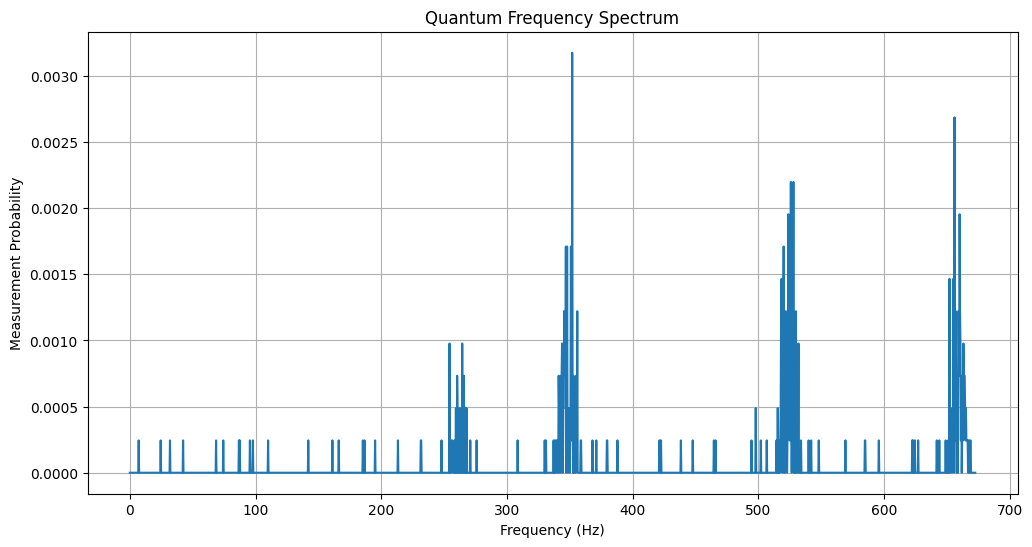

In [18]:
n_qubits = qc.num_qubits
probabilities = np.zeros(2**n_qubits)
for state, prob in quasi_dists.items():
    idx = int(state, 2)  
    probabilities[idx] = prob

sample_rate = 44100  
frequencies = np.fft.fftfreq(2**n_qubits, d=1/sample_rate)

plt.figure(figsize=(12, 6))
plt.plot(frequencies[:2000], probabilities[:2000])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Measurement Probability")
plt.title("Quantum Frequency Spectrum")
plt.grid(True)
